# Optimization

In this tutorial, we will cover:

* Continuous Optimization
    + Solving continuous optimization problems
* Reminder: multivariate calculus
* Gradient Descent
    + Why does GD work?
    + Selecting the learning rate
    + What can go wrong?
* Stochastic gradient descent
* Advanced optimizers
* Working example
* PyTorch's optimization API - *torch.optim*
* Learning rate scheduling
* Projected Gradient Descent (PGD)
    + Use case: adversarial attacks


<p align="center">
<img src="https://www.ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif">
</p>

## Continuous Optimization

Continious optimization problems are fundumental in Computer Science.

May be either unconstrained:
$$ \min_x f(x) \\ f: \mathbb{R}^d \rightarrow \mathbb{R}$$
Or constrained:
$$ \min_x f(x)
\text{ subject to } x \in \mathcal{K} \\
f: \mathbb{R}^d \rightarrow \mathbb{R} \text{, } \mathcal{K} \subseteq \mathbb{R}^d \text{ is closed and convex} $$

Many problems in CS can be written as a continous optimization problems:
* Linear programs (LPs)

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/3dpoly.svg/220px-3dpoly.svg.png">
</p>

* Linear Regression:

$$ \min_w \| Xw - y \|^2 \\
\text{where } X \in \mathbb{R}^{n \times d}, y \in \mathbb{R}^n $$


* Hard SVMs:

$$ \min_{w,b} \|w\|^2 \\
  \text{subject to } y_i (w^T x_i-b) \geq 1 $$

* **Empirical risk minimization of deep models** 

<p align="center">
<img src="https://www.fromthegenesis.com/wp-content/uploads/2018/06/Gradie_Desce.jpg">
</p>

### Solving Continious Optimization Problems

In some cases, continious optimization problems may be solved analytically:
* For unconstrained problems, search for stationary points.
* For constrained problems, try applying Lagrange multipliers or KKT conditions.

However, modern deep architectures include millions (sometimes billions) of parameters...
the loss function is summed over all the dataset (**memory burden**)
and the loss surface is often very noisy!

Therefore, efficient iterative optimization algorithms are required!

<p align="center">
<img src="https://huggingface.co/blog/assets/33_large_language_models/01_model_size.jpg"  width="30%" height="30%">
</p>


## Reminder: multivariate calculus

We will be mainly interested in functions $f: \mathbb{R}^d \rightarrow \mathbb{R}$.

The generalization of the derivative in the multivariate case is denoted as the **gradient**, which is composed of the **partial derivatives**:
$$ \nabla_x f = (\frac{\partial f}{\partial x_1},...,\frac{\partial f}{\partial x_d}) \in \mathbb{R}^d $$

The gradient gives us local information about the direction of the **largest ascent**:

<p align="center">
<img src="paraboloid.png">
</p>

If the gradient at some point $x \in \mathbb{R}^d$ is $\vec{0}$ then $x$ is called a **stationary point**.

<!---
Redundant
For functions with multiple outputs $f: \mathbb{R}^d \rightarrow \mathbb{R^m}$ , the gradient is generalized to a **Jacobian**:

$$ J_x(f) = 
\begin{pmatrix}
            \frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_d} \\
            \vdots & \ddots & \vdots \\
            \frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_d} \\
        \end{pmatrix}
\in \mathbb{R}^{m \times d} $$
-->

The second derivative of a function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ is defined by computing the gradient of each of the partial derivatives.

The resulting matrix is defined as the **Hessian** of $f$:
$$
\nabla^2_x f = 
\begin{pmatrix}
            \frac{\partial^2 f}{\partial x_1 \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_d} \\
            \vdots & \ddots & \vdots \\
            \frac{\partial^2 f}{\partial x_d \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_d \partial x_d} \\
        \end{pmatrix}
\in \mathbb{R}^{d \times d} $$

## Gradient Descent

* Iterative algorithm for solving continious optimization problems.
* Exploit local information from the current guess to produce the next guess.
* Idea: move along the anti-gradient direction of the currrent guess:

$$ x_{k+1} = x_k - \eta \nabla_x f (x_k) $$

We denote $ \eta $, which determines the step size as the **learning rate**.

### Why does GD work?

Why does GD work?

By using first order Taylor's approximation around $x_k$:
$$ f(x_k + \delta) = f(x_k) + \nabla_x f(x_k)^T \delta + o(\| \delta\|)$$
Substituting $\delta = - \eta \nabla_x f (x_k)$:
$$ f(x_{k+1}) = f(x_k) - \eta \| \nabla_x f(x_k) \|^2 + o(\| \delta\|)$$
If $x_k$ is not a stationary point, then for a small enough $\eta > 0 $ we have that $f$ strictly decreases.

### Selecting the learning rate

* Selecting the right learning rate is very important!
* Selecting too small learning rate would yield to a very slow optimization process ("**under-damped**").
* Selecting too large learning rate would yield to a jumpy process ("**over-damped**").
* Selecting a very large learning rate would cause the optimization process to diverge!

<p align="center">
<img src="example.gif" height=60%, width=60%>
</p>

* What is the optimal learning rate?
* For quadratic objectives, $\eta_{opt} = \frac{1}{\lambda_{max}}$ where $\lambda_{max}$ is the largest eigenvalue of the (constant) hessian matrix.
* For general objectives, computing $\lambda_{max}$ in every iteration is hard.
* In practice: perform manual or black-box tuning.
* Check out [optuna](https://optuna.org/).

### What can go wrong?

<p align="center">
<img src="https://nbviewer.org/github/vistalab-technion/cs236781-tutorials/blob/master/t01%20-%20linear%20models/imgs/sgd2d_2.png" height=25%, width=25%>
</p>

* The loss surface of DNNs is highly non-convex!
* GD depends on initialization. May converge to a **local minimum** rather than a **global minimum**!
* Another issue with GD is that it considers all the samples together (memory and computation burdens)!

## Stochastic Gradient Descent

* In our case the optimization objective can be decomposed as a sum (mean) of objectives on each sample:
$$ f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x) $$
* Recall that $n$ is very large.
* Idea: sample an index, and compute the gradient on a single datum:
$$ i \leftarrow Uniform(\{1,...,n\}) \\ 
x_{k+1} \leftarrow x_k - \eta \nabla f_i(x_k)$$
* In expectation the gradient is exact! However, the variance is very high!
* Optimization process becomes very noisy!
* Idea: instead of sampling a single datum, sample a **batch(mini-batch)** of samples.
* In practice: shuffle the dataset and split it into **mini-batches**. Each iteration over the whole dataset is called an **epoch**.


<p align="center">
<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/batch-1-1024x670.png" width=25%, height=25%>
</p>

## Advanced optimizers

* Heavy ball momentum
    + Idea: accumulate velocity from prior iterations!
    + Models the physics of a ball that is rolling downhill.
    <p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:640/1*zVi4ayX9u0MQQwa90CnxVg.gif", width=25%, height=25%>
    </p>
    + Momentum is modeled by an exponential moving average of the gradients in the prior steps:
    
    $$ v_{k+1} \leftarrow \gamma v_k + (1-\gamma) g_k \\ x_{k+1} \leftarrow x_k - \eta v_{k+1} $$


* AdaGrad
    + Stands for Adaptive Gradient.
    + Idea: the Hessian matrix may be very unbalanced, so use different effective learning rate for each parameter.
    <p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*WRtvrr9Z0QcokiKlgU7xEw.gif", width=25%, height=25%>
    </p>
    
    + Mathematically: 
    $$ G_{k+1} \leftarrow G_k + g_k \cdot g_k \\ x_{k+1} \leftarrow x_k - \frac{\eta}{\sqrt{G_{k+1} + \epsilon}} \cdot g_k $$

    + Note that in the above formulation $\cdot$ multiplication and the division is done **elementwise**.
    + $\epsilon$ is added to the denominator for numerical stability.


* Rmsprop
    + The problem of Adagrad is that the denominator keeps growing, and hence becomes very slow.
    + The solution is to use an EMA of the squared gradients instead:

    $$ v_{k+1} \leftarrow \beta v_k + (1-\beta) g_k \cdot g_k \\ x_{k+1} \leftarrow x_k - \frac{\eta}{\sqrt{v_{k+1} + \epsilon}} \cdot g_k $$

    <p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:640/1*_4zyVpZazh4OSIzprmYQEw.gif", width=25%, height=25%>
    </p>

* Adam
    + Stands for Adaptive Moment Estimation.
    + Essentially a combination of momentum and rmsprop:
    $$
        m_{k+1} \leftarrow \beta_1 m_k + (1-\beta_1) g_k \\
        v_{k+1} \leftarrow \beta_2 v_k + (1-\beta_2) g_k \cdot g_k \\
        \hat{m}_{k+1} \leftarrow \frac{m_{k+1}}{1-\beta_1^{k+1}}, \quad \hat{v}_{k+1} \leftarrow \frac{v_{k+1}}{1-\beta_2^{k+1}} \\
        x_{k+1} \leftarrow x_k - \frac{\eta}{\sqrt{\hat{v}_{k+1} + \epsilon}} \cdot \hat{m}_{k+1}
    $$
    + The most common optimizer today.

* Which optimizer to use?
    + Adam would be a good place to start.
    + However, **for some tasks it is better to use other optimizers**.
    + For instance, simple SGD with momentum works the best for optimizing ResNet!

## Working example

Let's demonstrate SGD for training a simple MLP architecture for performing hand-written digit recognition.

In [1]:
# Imports
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Define an MLP architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.in_dim = 784
        self.hidden_dim = 120
        self.out_dim = 10

        self.flatten = nn.Flatten() # (B,H,W) -> (B,D)
        self.linear = nn.Linear(self.in_dim, self.hidden_dim)
        self.activation = nn.ReLU()
        self.classifier = nn.Linear(self.hidden_dim, self.out_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.activation(x)
        x = self.classifier(x)
        return x
    
model = Net() # Instantiate model

In [3]:
# Define the training dataset
transform = transforms.Compose([
            transforms.ToTensor(), # Convert to tensor
            transforms.Normalize((0.1307,), (0.3081,)) # Subtract from values 0.13 then divide by 0.31
            ])

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform) # MNIST train set

In [4]:
# Define dataloader 
batch_size = 64
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # Different order in each epoch

On each batch, optimization can be summarized as follows:
* Loss computation on the current batch.
* Loss gradient computation w.r.t each of the model params.
* perfrom SGD step.

In [5]:
# Actual Training loop
num_epochs = 1
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()
losses = [] # For plotting

model.train() # Training mode
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # 1. Compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # 2. Magically compute gradient
        grad = torch.autograd.grad(loss, model.parameters())

        # 3. Perform optimization step
        for param, g in zip(model.parameters(), grad):
            param.grad = g
            param.data -= lr * param.grad

        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch {batch_idx+1} | loss: {loss.item()}')

Epoch [1/1] | Batch 1 | loss: 2.2692148685455322
Epoch [1/1] | Batch 2 | loss: 2.2100679874420166
Epoch [1/1] | Batch 3 | loss: 2.027266263961792
Epoch [1/1] | Batch 4 | loss: 1.8630539178848267
Epoch [1/1] | Batch 5 | loss: 1.8929814100265503
Epoch [1/1] | Batch 6 | loss: 1.6044684648513794
Epoch [1/1] | Batch 7 | loss: 1.475663423538208
Epoch [1/1] | Batch 8 | loss: 1.3381201028823853
Epoch [1/1] | Batch 9 | loss: 1.1293433904647827
Epoch [1/1] | Batch 10 | loss: 1.2795214653015137
Epoch [1/1] | Batch 11 | loss: 1.0670692920684814
Epoch [1/1] | Batch 12 | loss: 0.9152774214744568
Epoch [1/1] | Batch 13 | loss: 0.8227441310882568
Epoch [1/1] | Batch 14 | loss: 0.8876625895500183
Epoch [1/1] | Batch 15 | loss: 0.6743249297142029
Epoch [1/1] | Batch 16 | loss: 0.7605699896812439
Epoch [1/1] | Batch 17 | loss: 0.7148019671440125
Epoch [1/1] | Batch 18 | loss: 0.8863875269889832
Epoch [1/1] | Batch 19 | loss: 0.7686529755592346
Epoch [1/1] | Batch 20 | loss: 0.729006290435791
Epoch [1/1] 

Lets plot the loss over time!

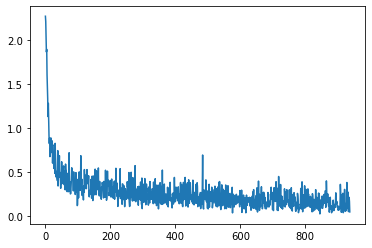

In [6]:
plt.plot(losses)

Let's see what happens when we decrease the batch size!

In [7]:
# This time, let's try with a smaller batch size!

model = Net() # re-initialize net

# re-define dataloader 
batch_size = 16
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Actual Training loop
num_epochs = 1
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()
losses = [] # For plotting

model.train() # Training mode
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # 1. Compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # 2. Magically compute gradient
        grad = torch.autograd.grad(loss, model.parameters())

        # 3. Perform optimization step
        for param, g in zip(model.parameters(), grad):
            param.grad = g
            param.data -= lr * param.grad

        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch {batch_idx+1} | loss: {loss.item()}')

Epoch [1/1] | Batch 1 | loss: 2.550872802734375
Epoch [1/1] | Batch 2 | loss: 2.272327184677124
Epoch [1/1] | Batch 3 | loss: 2.0798451900482178
Epoch [1/1] | Batch 4 | loss: 2.019272565841675
Epoch [1/1] | Batch 5 | loss: 2.008283853530884
Epoch [1/1] | Batch 6 | loss: 1.8231499195098877
Epoch [1/1] | Batch 7 | loss: 1.6534101963043213
Epoch [1/1] | Batch 8 | loss: 1.6480196714401245
Epoch [1/1] | Batch 9 | loss: 1.5524470806121826
Epoch [1/1] | Batch 10 | loss: 1.5912950038909912
Epoch [1/1] | Batch 11 | loss: 1.1226023435592651
Epoch [1/1] | Batch 12 | loss: 1.4697482585906982
Epoch [1/1] | Batch 13 | loss: 1.0499300956726074
Epoch [1/1] | Batch 14 | loss: 0.8054142594337463
Epoch [1/1] | Batch 15 | loss: 0.9630178809165955
Epoch [1/1] | Batch 16 | loss: 1.6144626140594482
Epoch [1/1] | Batch 17 | loss: 0.9706082344055176
Epoch [1/1] | Batch 18 | loss: 0.9603347182273865
Epoch [1/1] | Batch 19 | loss: 0.9181138277053833
Epoch [1/1] | Batch 20 | loss: 0.9964801073074341
Epoch [1/1] |

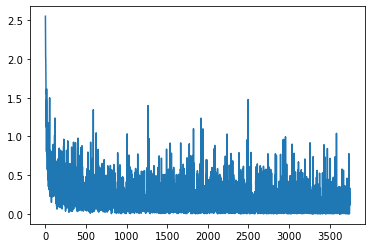

In [8]:
plt.plot(losses)

As we can observe, smaller batch yields to a more noisy optimization process.
This is due to high gradient variance!

## PyTorch's optimization API - *torch.optim*

* For performing optimization with ease, PyTorch includes an optimization interface named torch.optim.
* Supports numerous optimization algorithms!
* We will demonstrate the API by replacing the above training procedure. 

In [9]:
from torch.optim import SGD

In [10]:
model = Net() # re-initialize net
num_epochs = 1
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()

# re-define dataloader 
batch_size = 64
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define the optimizer
optimizer = SGD(model.parameters(), lr=lr)

model.train()
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # The three Musketeers!
        optimizer.zero_grad() # sets p.grad = 0 for all params
        loss.backward() # sets p.grad += dloss/dp
        optimizer.step() # performs actual optimization step

        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch {batch_idx+1} | loss: {loss.item()}')

Epoch [1/1] | Batch 1 | loss: 2.3790676593780518
Epoch [1/1] | Batch 2 | loss: 2.1210269927978516
Epoch [1/1] | Batch 3 | loss: 1.940892219543457
Epoch [1/1] | Batch 4 | loss: 1.8131083250045776
Epoch [1/1] | Batch 5 | loss: 1.8365105390548706
Epoch [1/1] | Batch 6 | loss: 1.5536680221557617
Epoch [1/1] | Batch 7 | loss: 1.6472917795181274
Epoch [1/1] | Batch 8 | loss: 1.531247854232788
Epoch [1/1] | Batch 9 | loss: 1.2547249794006348
Epoch [1/1] | Batch 10 | loss: 1.353220820426941
Epoch [1/1] | Batch 11 | loss: 1.1045948266983032
Epoch [1/1] | Batch 12 | loss: 1.0411723852157593
Epoch [1/1] | Batch 13 | loss: 0.9999468326568604
Epoch [1/1] | Batch 14 | loss: 0.819925844669342
Epoch [1/1] | Batch 15 | loss: 0.7688719630241394
Epoch [1/1] | Batch 16 | loss: 0.7433228492736816
Epoch [1/1] | Batch 17 | loss: 0.5915358662605286
Epoch [1/1] | Batch 18 | loss: 0.8329132199287415
Epoch [1/1] | Batch 19 | loss: 0.832962691783905
Epoch [1/1] | Batch 20 | loss: 0.7877292037010193
Epoch [1/1] | 

## Learning rate scheduling

* Observation: loss surface drastically changes over time and so is the hessian.
* Idea: change the learning rate over time.
* The most common practice is to reduce the learning rate after few epochs.
* Very useful in practice.

<p align="center">
<img src="https://www.researchgate.net/publication/332709751/figure/fig3/AS:752573329969153@1556438872095/Comparison-of-the-training-curves-The-left-compares-scale-ScaleNet-50-and-ResNet-50-on.png" width=25%, height=25%>
</p>

* Schedulers are also supported by torch.optim library!

In [11]:
from torch.optim.lr_scheduler import MultiStepLR

In [12]:
model = Net()
num_epochs = 2
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()

# define the optimizer and the scheduler
optimizer = SGD(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=[1], gamma=0.1) # reduce lr by 0.1 after 1 epoch

model.train()
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # The three Musketeers!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch {batch_idx+1} | loss: {loss.item()} | lr: {optimizer.param_groups[0]["lr"]}')
        losses.append(loss.item())

    scheduler.step() # Inform the scheduler an epoch was done!

Epoch [1/2] | Batch 1 | loss: 2.297530174255371 | lr: 0.1
Epoch [1/2] | Batch 2 | loss: 2.2116317749023438 | lr: 0.1
Epoch [1/2] | Batch 3 | loss: 2.1043801307678223 | lr: 0.1
Epoch [1/2] | Batch 4 | loss: 1.9877595901489258 | lr: 0.1
Epoch [1/2] | Batch 5 | loss: 1.8876607418060303 | lr: 0.1
Epoch [1/2] | Batch 6 | loss: 1.6155986785888672 | lr: 0.1
Epoch [1/2] | Batch 7 | loss: 1.7638261318206787 | lr: 0.1
Epoch [1/2] | Batch 8 | loss: 1.4920846223831177 | lr: 0.1
Epoch [1/2] | Batch 9 | loss: 1.3593358993530273 | lr: 0.1
Epoch [1/2] | Batch 10 | loss: 1.3291488885879517 | lr: 0.1
Epoch [1/2] | Batch 11 | loss: 1.0863240957260132 | lr: 0.1
Epoch [1/2] | Batch 12 | loss: 1.0341304540634155 | lr: 0.1
Epoch [1/2] | Batch 13 | loss: 0.969967782497406 | lr: 0.1
Epoch [1/2] | Batch 14 | loss: 0.9051041603088379 | lr: 0.1
Epoch [1/2] | Batch 15 | loss: 0.8547211289405823 | lr: 0.1
Epoch [1/2] | Batch 16 | loss: 0.8923367857933044 | lr: 0.1
Epoch [1/2] | Batch 17 | loss: 0.7887994647026062 |

Additional learning rate scheduling strategies include:
* Cosine annealing:
<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:1400/1*9hiywbEuoVXz4iX2-BDGZQ.png" width=20%, height=20%>
</p>

* Learning rate warmup:
<p align="center">
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/warmup_cosine_schedule.png">
</p>

## Projected Gradient Descent (PGD)

* So far, we have been concerned with **unconstrained** optimization problems.
* However, all of the above optimization algorithms may be generalized to **constrained** optimization problem of the following form:

$$ \min_x f(x)
\text{ subject to } x \in \mathcal{K} \\
f: \mathbb{R}^d \rightarrow \mathbb{R} \text{, } \mathcal{K} \subseteq \mathbb{R}^d \text{ is closed and convex} $$

* This is done by a simple-greedy agorithm named PGD.
* The idea is to project $x$ onto $\mathcal{K}$ after each iteration:
$$ \tilde{x}_{k+1} = x_k - \eta \nabla_x f (x_k) \\
x_{k+1} = \Pi_\mathcal{K}(\tilde{x}_{k+1})$$
* The algorithm can be proved to converge under the same conditions required for GD to converge!

<p align="center">
<img src="https://qph.cf2.quoracdn.net/main-qimg-8311c35651e61b7b91e8918388946469" width=25%, height=25%>
</p>


* Mathematically, the projection of a point onto a set is defined as the closest point to the original point within the set:
$$ \Pi_{\mathcal{K}}(x) := \arg \min_y \| y-x \| \text{ subject to } y \in \mathcal{K}$$
* Common projections:
    + A canonical sphere with radius $R$:
    $$ \Pi_{\mathcal{B}(R)}(x) = \min\{\frac{R}{\| x \|}, 1\} \cdot x $$
    <p align="center">
    <img src="http://pi.math.cornell.edu/~dwh/books/eg99/Ch16/37850c60.jpg" width=25%, height=25%>
    </p>
    
    + A linear subspace $W$:
    $$ \Pi_{W}(x) = \sum_{i=1}^m \langle x , \; w_i \rangle w_i $$
    where $\{ w_1, ..., w_m\}$ is an orthonormal basis for $W$.

    <p align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png">
    </p>
    
    

### Use case: adversarial attacks

* The goal is to find a small perturbation on a certain input, in a way which would cause the model to generate a wrong prediction.

<p align="center">
<img src="https://i.stack.imgur.com/5rfe9.png">
</p>

* Let's carry a PGD attack on a sample from the test dataset with respect to our trained model!

In [13]:
# Define the test dataset
transform = transforms.Compose([
            transforms.ToTensor(), # Convert to tensor
            transforms.Normalize((0.1307,), (0.3081,)) # Subtract from values 0.13 then divide by 0.31
            ])

dataset = datasets.MNIST('./data', train=False, download=True, transform=transform) # MNIST test set
sample_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
sample, true_y = next(iter(sample_loader))
sample = sample.detach()

Text(0.5, 1.0, 'Ground Truth: 7\nPrediction: 7, confidence: 99.95%')

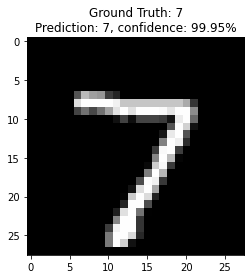

In [14]:
# Visualize the sample
with torch.no_grad():
    logit = model(sample)[0]
    proba = torch.softmax(logit, dim=0)
    pred = torch.argmax(proba)

fig = plt.figure()
plt.imshow(sample.reshape(28,28), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}\nPrediction: {}, confidence: {:.2f}%".format(true_y.item(), pred, proba[pred]*100))

In [15]:
attacked_sample = sample.clone()
attacked_sample.requires_grad = True
adversarial_optimizer = SGD([attacked_sample], lr=1e-1, maximize=True) # Increase loss instead of minimizing it!
eps = 5
n_iters = 10_000
loss_fn = nn.CrossEntropyLoss()

for iter in range(n_iters):
    logits = model(attacked_sample)
    loss = loss_fn(logits, true_y)

    # Gradient step
    adversarial_optimizer.zero_grad()
    loss.backward()
    adversarial_optimizer.step()

    # Projection!
    delta = attacked_sample.data - sample.data
    delta *= min(1,eps/torch.norm(delta))
    attacked_sample.data = sample + delta

    print(f'Iteration [{iter}] | loss: {loss.item()}')

Iteration [0] | loss: 0.0005261705373413861
Iteration [1] | loss: 0.0005261705373413861
Iteration [2] | loss: 0.0005261705373413861
Iteration [3] | loss: 0.0005261705373413861
Iteration [4] | loss: 0.0005264088395051658
Iteration [5] | loss: 0.0005265279905870557
Iteration [6] | loss: 0.0005265279905870557
Iteration [7] | loss: 0.0005266471416689456
Iteration [8] | loss: 0.0005266471416689456
Iteration [9] | loss: 0.0005267662927508354
Iteration [10] | loss: 0.0005268854438327253
Iteration [11] | loss: 0.0005268854438327253
Iteration [12] | loss: 0.0005268854438327253
Iteration [13] | loss: 0.0005270045949146152
Iteration [14] | loss: 0.000527123745996505
Iteration [15] | loss: 0.000527123745996505
Iteration [16] | loss: 0.000527123745996505
Iteration [17] | loss: 0.0005272428970783949
Iteration [18] | loss: 0.0005273620481602848
Iteration [19] | loss: 0.0005273620481602848
Iteration [20] | loss: 0.0005273620481602848
Iteration [21] | loss: 0.0005274811992421746
Iteration [22] | loss: 

Text(0.5, 1.0, 'Ground Truth: 7\nPrediction: 2, confidence: 89.97%')

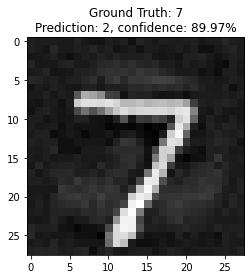

In [16]:
# Visualize the attacked sample

with torch.no_grad():
    logit = model(attacked_sample)[0]
    proba = torch.softmax(logit, dim=0)
    pred = torch.argmax(proba)

fig = plt.figure()
plt.imshow(attacked_sample.detach().numpy().reshape(28,28), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}\nPrediction: {}, confidence: {:.2f}%".format(true_y.item(), pred, proba[pred]*100))

* As can be observed the model mistakes with very high confidence on the perturbated sample.
* However, it is clear that the ground truth is still the same!

## Credits

* This tutorial was written by Mitchell Keren Taraday.
* Image credits:
    + [https://www.ruder.io/optimizing-gradient-descent/](https://www.ruder.io/optimizing-gradient-descent/)
    + [https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/3dpoly.svg/1024px-3dpoly.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/3dpoly.svg/1024px-3dpoly.svg.png)
    + [https://www.fromthegenesis.com/gradient-descent-part1/](https://www.fromthegenesis.com/gradient-descent-part1/)
    + [https://huggingface.co/blog/assets/33_large_language_models/01_model_size.jpg](https://huggingface.co/blog/assets/33_large_language_models/01_model_size.jpg)
    + [https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/batch-1-1024x670.png](https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/batch-1-1024x670.png)
    + [https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c)
    + [https://www.researchgate.net/publication/332709751_Data-Driven_Neuron_Allocation_for_Scale_Aggregation_Networks](https://www.researchgate.net/publication/332709751_Data-Driven_Neuron_Allocation_for_Scale_Aggregation_Networks)
    + [https://towardsdatascience.com/the-best-learning-rate-schedules-6b7b9fb72565](https://towardsdatascience.com/the-best-learning-rate-schedules-6b7b9fb72565)
    + [https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/warmup_cosine_schedule.png](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/warmup_cosine_schedule.png)
    + [https://home.ttic.edu/~nati/Teaching/TTIC31070/2015/Lecture16.pdf](https://home.ttic.edu/~nati/Teaching/TTIC31070/2015/Lecture16.pdf)
    + [https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png)
    + [https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png)
    + [https://i.stack.imgur.com/5rfe9.png](https://i.stack.imgur.com/5rfe9.png)
    + [http://www.cohennadav.com/files/icermw19_slides.pdf](http://www.cohennadav.com/files/icermw19_slides.pdf)